In [1]:
# file: core.py

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from math import pi as π
epsilon = np.finfo(np.float64).eps
from scipy.special import erf
from numpy import cos, sin, exp

In [2]:
from quantum_plots import *

Global props:
fontsizes :
     tiny :  6
     scriptsize :  8
     footnotesize :  9
     small :  10
     normalsize :  11
     large :  12
     Large :  14
     LARGE :  17
     huge :  20
     Huge :  25
colors :
     quantumviolet :  #53257F
     quantumgray :  #555555


## Probability samplings

### a) Grover-Rudolph probability states

The GR quantum representation of a probability distribution $p(x)$ over an interval $[a,b]$ with a discretization of $2^m$ points is given by the state
$$|\psi\rangle = \sum_s \sqrt{p^{(m)}(x_s)}|s\rangle$$
with the sampled coordinates
$$x_s = a + \frac{b-a}{2^m}s = a + \delta_m s,\;s=0,1,2\ldots 2^m-1.$$
and the coarse grained probabilities
$$p^{(m)}(x_s) := \int_{x_s}^{x_s+\delta_m} p(w) \mathrm{d}w.$$

One way to do this is to sample more finely the probabilities, subdividing the intervals $[x_s,x_s+\delta_m]$ into $2^k$ subintervals, and use precise approximation for that.

In [3]:
# file: core.py

def GR_state(m, p, a, b, k=None, normalize=True):
    """Given a function of one variable p(x), an interval [a,b] and
    a sampling of 2**m points, estimate the integrals of p(x) in
    each of the intervals.
    
    Arguments
    ---------
    m  -- log2 of the sampling size
    p  -- callable object that returns the probability p(x)
    a  -- beginning of interval
    b  -- end of interval (b>a)
    k  -- log2 of the subdivisions of 'm' to estimate the integrals
    normalize -- True if we adjust the norm of ψ
    
    Output
    ------
    ψ  -- probability state
    x  -- sampling interval
    """
    if k is None:
        k = 4
    # This is the desired sampling interval
    rm = a+(b-a)*np.arange(2**m)/2**m
    #
    # We subsample this interval, creating new coordinates
    # that provide a more accurate estimate of the integral
    ϵk = (b-a)*np.arange(2**k+1)/2**(m+k)
    w = rm.reshape(2**m,1)+ϵk.reshape(1,2**k+1)
    #
    # Use Scipy's Simpson's rule for integration
    pw = simps(p(w), w[0,:], axis=-1)
    #
    # Maybe correct small rounding errors and imprecisions
    # in simps() due to limited sampling
    if normalize:
        pw /= np.sum(pw)
    return np.sqrt(pw), rm

This other variant assumes we have an explicit formula for the integral of $p(x)$

In [4]:
# file: core.py

def GR_state_exact(m, p_int, a, b, k=None, normalize=True):
    """Given a function of one variable p(x), an interval [a,b] and
    a sampling of 2**m points, estimate the integrals of p(x) in
    each of the intervals.
    
    Arguments
    ---------
    m      -- log2 of the sampling size
    p_int  -- callable object such that p_int(a,b) returns the
              integral of p(x) among those extremes
    a      -- beginning of interval
    b      -- end of interval (b>a)
    
    Output
    ------
    ψ  -- probability state
    x  -- sampling interval
    """
    if k is None:
        k = 4
    # This is the desired sampling interval
    rm = a+(b-a)*np.arange(2**m+1)/2**m
    #
    # Exact integration
    pw = p_int(rm[:-1],rm[1:])
    #
    # Maybe correct small rounding errors and imprecisions
    # in simps() due to limited sampling
    if normalize:
        pw /= np.sum(pw)
    return np.sqrt(pw), rm[:-1]

### b) Trivial sampling

This is a brute force sampling of the probability, whereby we just take a discrete set of points and draw values from them
$$|\psi\rangle = \frac{1}{N^{1/2}}\sum_{s=0}^{2^m-1} \sqrt{p(x_s)}|s\rangle,$$
with an approximate normalization
$$N = \sum_s p(x_s) .$$

In [5]:
# file: core.py

def TS_state(m, p, a, b, normalize=True):
    """Given a function of one variable p(x), an interval [a,b] and
    a sampling of 2**m points, return a quantum state associated to
    the discretized sampling of the probability distribution.
    
    Arguments
    ---------
    m  -- log2 of the sampling size
    p  -- callable object that returns the probability p(x)
    a  -- beginning of interval
    b  -- end of interval (b>a)

    Output
    ------
    ψ  -- probability state
    x  -- sampling interval
    """
    # This is the desired sampling interval
    rm = a+(b-a)*np.arange(2**m)/2**m
    #
    # Use Scipy's Simpson's rule for integration
    pw = p(rm) * (rm[1]-rm[0])
    #
    # Maybe correct small rounding errors and imprecisions
    # in simps() due to limited sampling
    if normalize:
        pw /= np.sum(pw)
    return np.sqrt(pw), rm

## Particular states

### a) Gaussian probability distribution

In [6]:
# file: core.py

def Gaussian(x, σ, μ=0):
    return np.exp(-(x-μ)**2/(2*σ**2))/(np.sqrt(2*π)*σ)

def Gaussian_integral(a, b, σ, μ=0):
    sqrt2=np.sqrt(2.)
    return 0.5*(erf((b-μ)/(sqrt2*σ))-erf((a-μ)/(sqrt2*σ)))

def Gaussian_GR(m, σ, μ=0, a=None, b=None, method='exact', **kwdargs):
    if a is None:
        a = μ-6*σ
    if b is None:
        b = μ+6*σ
    if method == 'exact':
        return GR_state_exact(m, lambda a,b: Gaussian_integral(a,b,σ,μ),
                              a, b, **kwdargs)
    elif method == 'sampling':
        return TS_state(m, lambda x: Gaussian(x,σ,μ), a, b, **kwdargs)
    elif method == 'integrate':
        return GR_state(m, lambda x: Gaussian(x,σ,μ), a, b, **kwdargs)
    else:
        raise Exception(f'Unknown method {method}')

In [7]:
aux_ψ, aux_x = Gaussian_GR(8, σ=1, method='exact', normalize=False)
aux_ψ2, aux_x = Gaussian_GR(8, σ=1, method='integrate', normalize=False)
aux_ψ3, _ = Gaussian_GR(8, σ=1, method='sampling', normalize=False)

Normalization exact = 0.9999999980268247
Normalization numerics = 0.9999999980268247
Normalization sampling = 0.9999999980268247


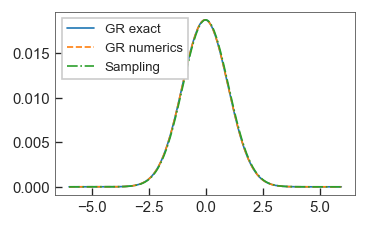

In [8]:
fig = plot_setup()
plt.plot(aux_x, aux_ψ**2, '-', label='GR exact');
plt.plot(aux_x, aux_ψ2**2, '--', label='GR numerics');
plt.plot(aux_x, aux_ψ3**2, '-.', label='Sampling');
plt.legend(fontsize=8)
print(f'Normalization exact = {np.sum(aux_ψ**2)}')
print(f'Normalization numerics = {np.sum(aux_ψ**2)}')
print(f'Normalization sampling = {np.sum(aux_ψ**2)}')

### b) Lognormal distribution

A popular probability distribution used in finance
$$p(x) \propto \frac{1}{x} e^{-((\log(x)-\mu)/\sigma)^2},$$
defined over positive coordinates $x\geq 0.$$

In [9]:
# file: core.py

def Lognormal(x, σ, μ=0):
    return Gaussian(np.log(x),σ,μ)/(x+epsilon)

def Lognormal_integral(a, b, σ, μ=0):
    return Gaussian_integral(np.log(a), np.log(b), σ, μ)

def Lognormal_GR(m, σ, μ=1., a=None, b=None, method='exact', **kwdargs):
    if a is None:
        a = epsilon
    if b is None:
        b = μ+50*σ
    if method == 'exact':
        return GR_state_exact(m, lambda a,b: Lognormal_integral(a,b,σ,μ),
                              a, b, **kwdargs)
    elif method =='integrate':
        return GR_state(m, lambda x: Lognormal(x,σ,μ), a, b, **kwdargs)
    elif method == 'sampling':
        return TS_state(m, lambda x: Lognormal(x,σ,μ), a, b, **kwdargs)
    else:
        raise Exception(f'Unknown method {method}')

In [10]:
aux_ψ, aux_x = Lognormal_GR(10, σ=1, method='exact', normalize=False)
aux_ψ2, aux_x = Lognormal_GR(10, σ=1, method='integrate')
aux_ψ3, _ = Lognormal_GR(10, σ=1, method='sampling')

Normalization exact = 0.998315120566396
Normalization numerics = 0.998315120566396
Normalization sampling = 0.998315120566396


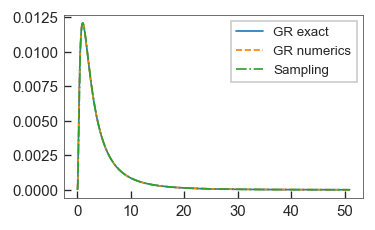

In [11]:
fig = plot_setup()
plt.plot(aux_x, aux_ψ**2, '-', label='GR exact');
plt.plot(aux_x, aux_ψ2**2, '--', label='GR numerics');
plt.plot(aux_x, aux_ψ3**2, '-.', label='Sampling');
plt.legend(fontsize=8)
print(f'Normalization exact = {np.sum(aux_ψ**2)}')
print(f'Normalization numerics = {np.sum(aux_ψ**2)}')
print(f'Normalization sampling = {np.sum(aux_ψ**2)}')

### c) Lorentzian distribution

Another probability distribution, characterized by its center $\mu$ and width $\sigma$
$$p(x) = \frac{1}{\pi}\frac{(\sigma/2)^2}{(x-\mu)^2 - (\sigma/2)^2}.$$

In [12]:
# file: core.py

def Lorentzian(x, σ, μ=0):
    γ=0.5*σ
    return (γ/π)/((x-μ)**2+γ**2)

def Lorentzian_integral(a, b, σ, μ=0):
    return (np.arctan((b-μ)*(2/σ))-np.arctan((a-μ)*(2/σ)))/π

def Lorentzian_GR(m, σ, μ=0., a=None, b=None, method='exact', **kwdargs):
    if a is None:
        a = μ-10*σ
    if b is None:
        b = μ+10*σ
    if method=='exact':
        return GR_state_exact(m, lambda a,b: Lorentzian_integral(a,b,σ,μ),
                              a, b, **kwdargs)
    elif method=='integrate':
        return GR_state(m, lambda x: Lorentzian(x,σ,μ), a, b, **kwdargs)
    elif method=='sampling':
        return TS_state(m, lambda x: Lorentzian(x,σ,μ), a, b, **kwdargs)
    else:
        raise Exception(f'Unknown method {method}')

In [13]:
aux_ψ, aux_x = Lorentzian_GR(10, σ=1, method='exact', normalize=False)
aux_ψ2, aux_x = Lorentzian_GR(10, σ=1, method='integrate')
aux_ψ3, _ = Lorentzian_GR(10, σ=1, method='sampling')

Normalization exact = 0.9681954974876472
Normalization numerics = 0.9681954974876472
Normalization sampling = 0.9681954974876472


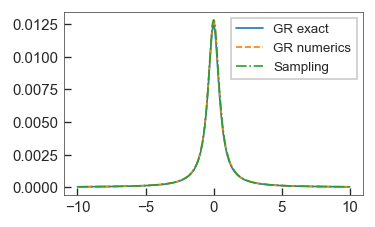

In [14]:
fig = plot_setup()
plt.plot(aux_x, aux_ψ**2, '-', label='GR exact');
plt.plot(aux_x, aux_ψ2**2, '--', label='GR numerics');
plt.plot(aux_x, aux_ψ3**2, '-.', label='Sampling');
plt.legend(fontsize=8)
print(f'Normalization exact = {np.sum(aux_ψ**2)}')
print(f'Normalization numerics = {np.sum(aux_ψ**2)}')
print(f'Normalization sampling = {np.sum(aux_ψ**2)}')

### d) Weird distribution

A multimodal distribution, with sufficient sines and cosines to make it non-trivial, but still bandwidth limited.

In [15]:
# file: core.py

from numpy import cos, exp, sin

def Weird(x, σ):
    σ2 = σ**2
    Nσ = (2-1/(1+100*σ2)-1/(1+4*σ2)-2/(1+16*σ2)+2/(1+36*σ2))/8
    return exp(-x)*(sin(2*σ*x)*cos(3*σ*x))**2/np.sqrt(Nσ)

def Weird1_integral(a, σ):
    σ2 = σ*σ
    Nσ = (2-1/(1+100*σ2)-1/(1+4*σ2)-2/(1+16*σ2)+2/(1+36*σ2))
    f = (-2 + cos(2*a*σ)/(1+4*σ2) + 2*cos(4*a*σ)/(1+16*σ2) - 2*cos(6*a*σ)/(1+36*σ2)
         + cos(10*a*σ)/(1+100*σ2) - 2*σ*sin(2*a*σ)/(1+4*σ2) - 8*σ*sin(4*a*σ)/(1+16*σ2)
         + 12*σ*sin(6*a*σ)/(1+36*σ2) - 10*σ*sin(10*a*σ)/(1+100*σ2))
    return 1+ exp(-a) * f / Nσ

def Weird_integral(a, b, σ):
    return Weird1_integral(b,σ) - Weird1_integral(a,σ)

def Weird_GR(m, σ, a=None, b=None, method='exact', **kwdargs):
    if a is None:
        a = 0
    if b is None:
        b = 9*σ
    if method=='exact':
        return GR_state_exact(m, lambda a,b: Weird_integral(a,b,σ),
                              a, b, **kwdargs)
    elif method=='integrate':
        return GR_state(m, lambda x: Weird(x,σ), a, b, **kwdargs)
    elif method=='sampling':
        return TS_state(m, lambda x: Weird(x,σ), a, b, **kwdargs)
    else:
        raise Exception(f'Unknown method {method}')

In [16]:
aux_ψ, aux_x = Weird_GR(10, σ=1, method='exact', normalize=False)
aux_ψ2, aux_x = Weird_GR(10, σ=1, method='integrate')
aux_ψ3, _ = Weird_GR(10, σ=1, method='sampling')

Normalization exact = 0.9999038436848309
Normalization numerics = 0.9999038436848309
Normalization sampling = 0.9999038436848309


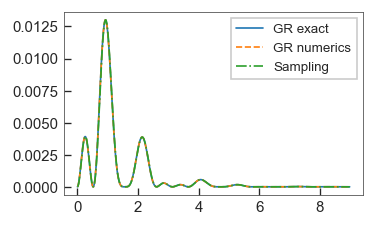

In [17]:
fig = plot_setup()
plt.plot(aux_x, aux_ψ**2, '-', label='GR exact');
plt.plot(aux_x, aux_ψ2**2, '--', label='GR numerics');
plt.plot(aux_x, aux_ψ3**2, '-.', label='Sampling');
plt.legend(fontsize=8)
print(f'Normalization exact = {np.sum(aux_ψ**2)}')
print(f'Normalization numerics = {np.sum(aux_ψ**2)}')
print(f'Normalization sampling = {np.sum(aux_ψ**2)}')

## Discretized Gaussian states

We are going to study multi-mode Gaussian probability distributions. These are defined by a covariance matrix $\Sigma$ and a vector of mean values, $\vec{\mu},$
$$p(\vec{x}) = \frac{1}{N}\exp\left[-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-2}(\vec{x}-\vec{\mu})\right].$$

There exists an orthogonal change of variables that diagonalizes the covariance matrix,
$$\Sigma = O^T \mathrm{diag}(\sigma_1,\sigma_2,\ldots,\sigma_N) O.$$
Introducing the new coordinates
$$\vec{u} = O(\vec{x}-\vec{\mu}),$$
we can recompute any expectation value
$$\bar{f}:=\int f(\vec{x}) p(\vec{x})\mathrm{d}^nx = \frac{1}{N} \int f(\vec{u}) \prod_i e^{\frac{1}{2\sigma_i^2}u_i^2}\mathrm{d}^nu.$$

The first outcome is that
$$N=\frac{1}{(2\pi)^{N/2}\prod\sigma_i} = \frac{1}{(2\pi)^{N/2}\mathrm{det}(\Sigma)}.$$

In [18]:
# file: core.py
import scipy.linalg

def GaussianNd(m, Σ, a=None, b=None, μ=0):
    #
    # Guess the dimension of the problem
    Σ = np.asarray(Σ)
    d = Σ.shape[0]
    μ = μ * np.ones(d)
    #
    # We diagonalize the covariance matrix to find the normal modes
    σ, OT = scipy.linalg.eigh(Σ)
    #
    # This information is useful to set limits to clip the state
    σmax = np.max(σ)
    if a is None:
        a = μ-7*σmax
    if b is None:
        b = μ+7*σmax
    if any(a==b):
        raise Exception(f'GaussianNd boundaries coincide\na={a}\nb={b}')
    #
    # We use the sampling method, creating a meshgrid that is large
    # enough to fit the Gaussian
    D = 2**m
    if d == 1:
        r = x = np.linspace(a[0],b[0],D).reshape(D,1)
    elif d == 2:
        x = np.linspace(a[0],b[0],D)
        y = np.linspace(a[1],b[1],D)
        r = np.zeros((D, D, 2))
        r[:,:,0], r[:,:,1] = np.meshgrid(x,y)
    elif d == 3:
        x = np.linspace(a[0],b[0],D)
        y = np.linspace(a[1],b[1],D)
        z = np.linspace(a[2],b[2],D)
        r = np.zeros((D, D, D, 3))
        r[:,:,:,0] = x.reshape(D,1,1)*np.ones((D,D,D))
        r[:,:,:,1] = y.reshape(1,D,1)*np.ones((D,D,D))
        r[:,:,:,2] = z.reshape(1,1,D)*np.ones((D,D,D))
    else:
        raise Exception('Dimension d={d} not supported in GaussianNd()')
    N = (2*π)**(d/2) * np.prod(σ)
    pw = np.exp(-0.5 * np.sum(((r @ OT) / σ)**2, -1))/N
    return np.sqrt(pw/np.sum(pw)), r

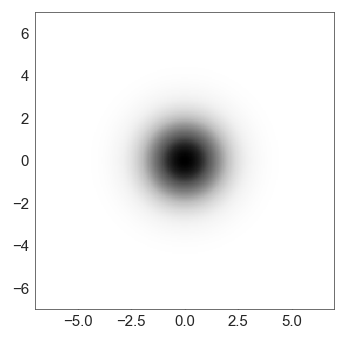

In [19]:
aux_ψ, aux_r = GaussianNd(8,np.diag([1,1]))
fig = plot_setup(aspect_ratio=1)
plt.pcolormesh(aux_r[:,:,0], aux_r[:,:,1], aux_ψ);

### 2D squeezed states

We can study squeezed states in 2d

In [20]:
# file: core.py

def cmatrix2d(σ, θ):
    O = np.array([[math.cos(θ), math.sin(θ)],
                  [-math.sin(θ), math.cos(θ)]])
    return O.T @ np.diag(σ) @ O

In [21]:
# file: core.py

def reorder2d(ψ, m, d=2):
    if False:
        l = 1
        for n in range(m):
            ψ = ψ.reshape(d, d**(m-n-1), d, d**(m-n-1), l)
            ψ = np.einsum('ijkrl->jrlik',ψ)
            l = l * d * d
    else:
        orig = [dim * m + i for i in range(m) for dim in range(d)]
        ψ = np.moveaxis(ψ.reshape([2]*(d*m)), orig, np.arange(d*m))
    return ψ.flatten()

Normalization: 0.9999999999999996


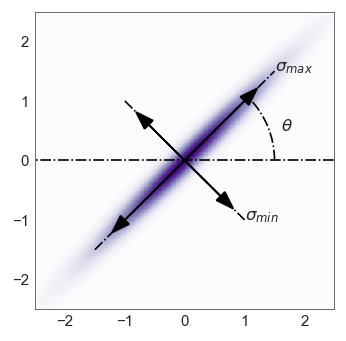

In [22]:
aux_ψ, aux_r = GaussianNd(10,cmatrix2d([1.0,0.1],π/4.))
fig = plot_setup(aspect_ratio=1)
print(f'Normalization: {np.sum(aux_ψ**2)}')

from matplotlib.patches import Arc
ax = fig.add_subplot(1,1,1)
ax.pcolormesh(aux_r[:,:,0], aux_r[:,:,1], aux_ψ, cmap='Purples');
v = np.linspace(-1,1,10)
ax.plot(1.5*v, 1.5*v, 'k-.')
ax.plot(v, -v, 'k-.')
ax.plot(3*v, 0*v, 'k-.')
ax.arrow(0,0,1,1,head_width=0.2,facecolor='k')
ax.arrow(0,0,-1,-1,head_width=0.2,facecolor='k')
ax.arrow(0,0,0.6,-0.6,head_width=0.2,facecolor='k')
ax.arrow(0,0,-0.6,0.6,head_width=0.2,facecolor='k')
ax.add_patch(Arc((0,0),3,3, theta1=0.0, theta2=45, edgecolor='k', linestyle='-.'))
ax.text(1.5, 1.5, '$\\sigma_{max}$');
ax.text(1, -1, '$\\sigma_{min}$');
ax.text(1.6, 0.5, '$\\theta$')
ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5]);

In [23]:
import os
import pickle
from time import process_time

def make_entropies2d(M=10, filename='entropies2d-m10.pkl'):
    def entropies(m, σ, θ, reorder=False):
        print(f'Running with m={m}, σ={σ}, θ={θ}')
        t0 = process_time()
        ψ, _, _ = GaussianNd(m, cmatrix2d(σ, θ))
        if reorder:
            ψ = reorder2d(ψ, m, 2)
        t1 = process_time() - t0
        print(f'State construction {t1}s')
        S = [Schmidt(ψ, i, 2*m-i)[0] for i in range(1,2*m)]
        t2 = process_time() - t1
        print(f'Entropies {S}')
        print(f'Full computation {t2}s')
        return S

    if not os.path.exists(filename):
        σs = np.linspace(0.1,1.,21)
        S1 = [max(entropies(M, [1.0, σ], 0)) for σ in σs]
        S2 = [max(entropies(M, [1.0, σ], π/3.)) for σ in σs]
        S3 = [max(entropies(M, [1.0, σ], π/4.)) for σ in σs]
        S4 = [max(entropies(M, [1.0, σ], π/4., True)) for σ in σs]
        with open(filename,'wb') as f:
            pickle.dump((M, σs, S1, S2, S3, S4), f)

In [24]:
make_entropies2d(M=5, filename='data/entropies2d-m5.pkl')

In [25]:
make_entropies2d(M=7, filename='data/entropies2d-m7.pkl')

In [26]:
make_entropies2d(M=10, filename='data/entropies2d-m10.pkl')

In [27]:
make_entropies2d(M=12, filename='data/entropies2d-m12.pkl')

In [28]:
make_entropies2d(M=14, filename='data/entropies2d-m14.pkl')

### 3D squeezed states

In [29]:
# file: core.py

def reorder3d(ψ, m, d=2):
    l = 1
    for n in range(m):
        ψ = ψ.reshape(d, d**(m-n-1), d, d**(m-n-1), d, d**(m-n-1), l)
        ψ = np.einsum('ijmnpql->jnqlimp',ψ)
        l = l * d * d * d
    return ψ.flatten()

In [30]:
# file: core.py

def cmatrix3d(σ, θ1, θ2):
    U1 = np.array([[1,0,0],
                   [0,math.cos(θ1), math.sin(θ1)],
                   [0,-math.sin(θ1), math.cos(θ1)]])
    U2 = np.array([[math.cos(θ2), math.sin(θ2), 0],
                   [-math.sin(θ2), math.cos(θ2), 0],
                   [0,0,1]])
    O = U1 @ U2
    return O.T @ np.diag(σ) @ O

In [31]:
from core import *
import os
import pickle

def make_entropies3d(M=7, filename='entropies3d.pkl'):
    def entropies(m, σ, θ, reorder=False):
        ψ, *_ = GaussianNd(m, cmatrix3d([σ, 1, σ], θ, θ))
        if reorder:
            ψ = reorder3d(ψ, m, 2)
        return [Schmidt(ψ, i, 3*m-i)[0] for i in range(1,3*m)]

    if not os.path.exists(filename):
        σs = np.linspace(0.1,1.,21)
        S1 = [max(entropies(M, σ, 0)) for σ in σs]
        S3 = [max(entropies(M, σ, π/4.)) for σ in σs]
        S4 = [max(entropies(M, σ, π/4., True)) for σ in σs]
        with open(filename,'wb') as f:
            pickle.dump((M, σs, S1, S3, S4),f)


In [32]:
make_entropies3d(M=5, filename='data/entropies3d-m5.pkl')

In [33]:
make_entropies3d(M=7, filename='data/entropies3d-m7.pkl')

### Study of entanglement

We use a Schmidt decomposition to gather the entropy of entanglement in a function $\psi$ encoded with $L+R$ qubits, which are assigned to two partitions.

In [34]:
# file: core.py
import scipy.linalg

def Schmidt(ψ, L, R, d=2):
    """Given a d^N state, with N=L+R, perform a decomposition into
    L and R subsystems and compute the Schmidt values and entropy."""
    s = scipy.linalg.svd(ψ.reshape(d**L, d**R), compute_uv = False,
                         lapack_driver='gesvd')
    λ = s*s
    λ /= np.sum(λ)
    λ = λ[np.where(λ>0)[0]]
    entropy = np.sum(-λ*np.log2(λ))
    return entropy, λ